FGSM on a simple fnn

In [1]:
from sklearn.datasets import load_digits
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

data_tensor = torch.tensor(digits.data, dtype=torch.float32)
data_tensor = torch.tensor(digits.data / 16.0, dtype=torch.float32) # Normalize for neat
target_tensor = torch.tensor(digits.target, dtype=torch.long)

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    data_tensor, target_tensor, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Batch is the full size because there is no backpropogation
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [3]:
len(train_dataset)

1437

In [4]:
# Simple FFN approach

class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8*8, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)

        logits = self.linear_relu_stack(x)
        return logits
        return F.softmax(logits, dim=0)

In [7]:
# Training loop

model = FFN()

epochs = 400

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(epochs):
    for data_batch, label_batch in train_loader:
        output = model(data_batch)
        loss = loss_fn(output, label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(loss.item())

2.31947660446167
2.256021499633789
2.192096471786499
2.1132774353027344
2.019395351409912
1.911458969116211
1.7906699180603027
1.6591330766677856
1.5204237699508667
1.3793058395385742
1.2411341667175293
1.1108441352844238
0.9920622706413269
0.8865486979484558
0.794504702091217
0.7150220274925232
0.6466823220252991
0.5879400372505188
0.5373164415359497
0.4935389757156372
0.455515593290329
0.42232492566108704
0.39320099353790283
0.36750519275665283
0.3447161912918091
0.3243710398674011
0.3061259984970093
0.2897055745124817
0.27488818764686584
0.26146233081817627
0.24922321736812592
0.23801802098751068
0.2277299016714096
0.21825653314590454
0.2095002382993698
0.2013828456401825
0.1938292682170868
0.18677860498428345
0.18016952276229858
0.17396798729896545


In [8]:
import matplotlib.pyplot as plt

def plot_img(img, label=None):
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray_r')
    if label is not None:
        plt.title(f"Label: {label}")
        
    plt.tight_layout()
    plt.show()

In [12]:
# FGSM

# new image = original image + perturbation scalar * neg (gradient with respect to the loss)

def FGSM(img, target, scalar=3):
    img = img.clone().view(-1).detach().requires_grad_(True)  # Input usually doesnt require grad
    y = model(img)
    loss = loss_fn(y, target)
    loss.backward()
    grad = img.grad.data
    signed_grad = grad.sign()
    mod_img = img + (scalar * signed_grad)
    return mod_img.detach()

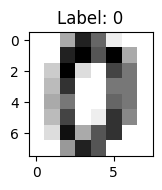

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 64x32)

In [13]:
plot_img(data_tensor[0].view(8, 8), torch.argmax(target_tensor[0]))

modified = FGSM(data_tensor[0], target_tensor[0])
modified_label = torch.argmax(model(modified))

plot_img(modified.view(8, 8), modified_label)

In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in train_loader:
        data = data
        labels = labels
        
        outputs = model(data)  # logits
        predicted = torch.argmax(outputs, dim=1)  # class indices

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.29%


In [10]:
torch.save(model, f"../models/fnn{accuracy * 100:.2f}.pth")